<a href="https://colab.research.google.com/github/okolenchuk/DS_HW_NLP/blob/main/task_1_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os, re
import pandas as pd
import numpy as np
import math
import string

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import *

from collections import Counter, defaultdict

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# **Загрузка и предобработка данных**

Data import for Google colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/bbc'

Mounted at /content/drive


Data import for Kaggle

In [ ]:
data_path = '../input/bbc-news'

Пройдемся по дирректории с файлами датасета и соберем все в датафрейм text + label

In [3]:
directory = []
file = []
title = []
text = []
label = []
 
for dirname, _ , filenames in os.walk(data_path):
    for filename in filenames:
        directory.append(dirname)
        file.append(filename)
        label.append(dirname.split('/')[-1])
        fullpathfile = os.path.join(dirname,filename)
        with open(fullpathfile, 'r', encoding="utf8", errors='ignore') as infile:
            intext = ''
            firstline = True
            for line in infile:
                if firstline:
                    title.append(line.replace('\n',''))
                    firstline = False
                else:
                    intext = intext + ' ' + line.replace('\n','')
            text.append(intext)

In [4]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'

fulldf = pd.DataFrame(list(zip(directory, file, title, text, label)), 
               columns =['directory', 'file', 'title', 'text', 'label'])

df = fulldf.filter(['text','label'], axis=1)
df.head()

,text,label
0,Uganda's authorities have banned the play Th...,entertainment
1,The plot of an international bestseller that...,entertainment
2,The 10 authors shortlisted for a Richard and...,entertainment
3,Hollywood film star Liam Neeson has held a d...,entertainment
4,"Young book fans have voted Fergus Crane, a s...",entertainment


In [5]:
df.shape

(2231, 2)

In [6]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [7]:
labels = df.label.unique()
labels

array(['entertainment', 'tech', 'sport', 'politics', 'business'],
      dtype=object)

Посмотрим на распределение целевое переменной. На графике видим, что значительных отличий в представлении классов нет.

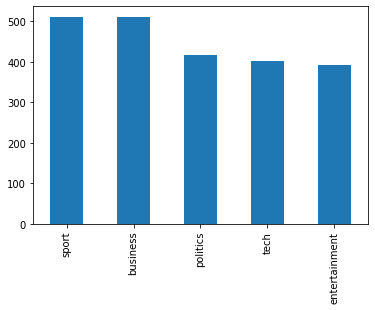

In [8]:
df['label'].value_counts().sort_values(ascending=False).plot(kind='bar');

In [ ]:
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])
df.head()

Дальше проводим очиству, лемматиацию и векторизацию текста новостей.

In [10]:
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [11]:
lemmatizer = WordNetLemmatizer()
regex = re.compile("[А-Яа-я:=!\)\()A-z\_\%/|]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""


def lemmatize(text, lemmatizer=lemmatizer):
    try:
        return " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    except:
        return " "

In [12]:
df.text = df.text.apply(words_only)
df.head()

,text,label,label_enc
0,Uganda s authorities have banned the play The ...,entertainment,1
1,The plot of an international bestseller that t...,entertainment,1
2,The authors shortlisted for a Richard and Judy...,entertainment,1
3,Hollywood film star Liam Neeson has held a din...,entertainment,1
4,Young book fans have voted Fergus Crane a stor...,entertainment,1


In [13]:
df.text = df.text.apply(lemmatize)
df.head()

,text,label,label_enc
0,Uganda s authority have banned the play The Va...,entertainment,1
1,The plot of an international bestseller that t...,entertainment,1
2,The author shortlisted for a Richard and Judy ...,entertainment,1
3,Hollywood film star Liam Neeson ha held a dinn...,entertainment,1
4,Young book fan have voted Fergus Crane a story...,entertainment,1


In [15]:
import gensim.downloader as api
word2vec = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [16]:
tokenizer = nltk.WordPunctTokenizer()
def tokenize_and_vectorize(sent, tokenizer=tokenizer, vectorizer=word2vec):
    tokens = tokenizer.tokenize(sent.lower())
    vectors = np.mean([word2vec.get_vector(w) for w in tokens if w in word2vec] 
                      or [np.zeros(300)], axis=0)
    return vectors
    

df['text_v'] = df.text.apply(tokenize_and_vectorize)
df.head()

,text,label,label_enc,text_v
0,Uganda s authority have banned the play The Va...,entertainment,1,"[0.027610779, 0.032774433, 0.04872701, 0.04561..."
1,The plot of an international bestseller that t...,entertainment,1,"[0.035204053, 0.020581473, 0.014687492, 0.0848..."
2,The author shortlisted for a Richard and Judy ...,entertainment,1,"[-0.0066544362, 0.045021188, 0.010201244, 0.09..."
3,Hollywood film star Liam Neeson ha held a dinn...,entertainment,1,"[0.0404645, 0.0460742, 0.024664301, 0.07234362..."
4,Young book fan have voted Fergus Crane a story...,entertainment,1,"[0.0054060826, 0.03553495, 0.032416623, 0.0525..."


При помощи PCA и TSNE посмотрим на распределение классов, видим на графике, что в целом классы отличны друг от друга и могут быть разделемы классическими алгоритмами классификации.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


pca = PCA(n_components=2)
tsne = TSNE(n_components=2)
PCA = pca.fit_transform(np.array(df.text_v.to_list())) 
TSNE = tsne.fit_transform(np.array(df.text_v.to_list()))

In [54]:
%matplotlib inline

In [55]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

In [56]:
draw_vectors(
    PCA[:, 0], 
    PCA[:, 1], 
    color=[['red', 'blue', 'green', 'violet', 'yellow'][t] for t in df.label_enc]
    )

Figure(id='1363', ...)

In [21]:
draw_vectors(
    TSNE[:, 0], 
    TSNE[:, 1], 
    color=[['red', 'blue', 'green', 'violet', 'yellow'][t] for t in df.label_enc]
    )

Figure(id='1112', ...)

Подготовим для обучения и валидации train и test датасеты. 

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

df = shuffle(df)

X = df.text_v.tolist()
y = df.label.tolist()

X, y = np.array(X), np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

print ("total train examples %s" % len(y_train))
print ("total test examples %s" % len(y_test))

total train examples 1784
total test examples 447


Я выбрала для обучения модель Случайного леса.

In [47]:
from sklearn.ensemble import RandomForestClassifier

rfc_w2v = RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1)

In [48]:
rfc_w2v.fit(X_train,y_train)
pred = rfc_w2v.predict(X_test)

Precision:   0.94
Recall:   0.94
F1-measure:   0.94
Accuracy:   0.94
               precision    recall  f1-score   support

     business       0.90      0.96      0.93        92
entertainment       0.99      0.94      0.96        77
     politics       0.92      0.88      0.90        98
        sport       0.97      0.98      0.97        95
         tech       0.91      0.93      0.92        85

     accuracy                           0.94       447
    macro avg       0.94      0.94      0.94       447
 weighted avg       0.94      0.94      0.94       447



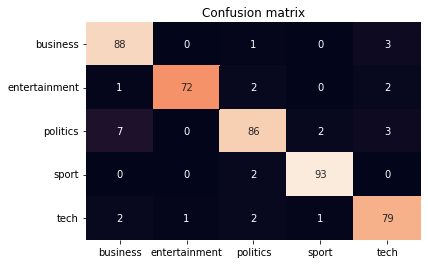

In [62]:
from sklearn.metrics import *
import seaborn as sns
import matplotlib.pyplot as plt

print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))

print(classification_report(y_test, pred))

labels = rfc_w2v.classes_

sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [50]:
y_pred_proba = rfc_w2v.predict_proba(X_test)
roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

0.9957705707162982

Как видим по всем метрикам выше модель отлично справилась с классификацией текста, ROC-AUC score **0.996**

## **BERT MODEL**

Для второй части задания загрузим предобученную модель трансформера Distil Bert и дообучим ее на нашем датасете.

In [ ]:
!pip install transformers;

In [28]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

import torch
import transformers
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

from tqdm import tqdm

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

Инициализируем гипермараметры

In [29]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 1e-05

In [30]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5,
                                                            problem_type="multi_label_classification")

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model.to(device);

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [31]:
class MultiLabelDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.label_ohe
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [32]:
from sklearn.preprocessing import OneHotEncoder
OHE = OneHotEncoder()
df['label_ohe'] = pd.get_dummies(df['label']).values.tolist()
df.head()

,text,label,label_enc,text_v,label_ohe
1821,Shares of Sumitomo Mitsui Financial (SMFG) and...,business,0,"[-0.01975999, 0.019744366, 0.0059153237, 0.058...","[1, 0, 0, 0, 0]"
1202,Top seed Roger Federer had to save two match p...,sport,3,"[-0.005381379, 0.052272942, 0.043338053, 0.075...","[0, 0, 0, 1, 0]"
1933,A shareholder in US phone firm MCI ha taken le...,business,0,"[-0.011499132, 0.027149633, 0.012896311, 0.035...","[1, 0, 0, 0, 0]"
1882,An ex chief financial officer at Boeing ha rec...,business,0,"[0.0006516714, 0.04363947, 0.04305926, 0.01657...","[1, 0, 0, 0, 0]"
1145,Former All Black star Jonah Lomu say he cannot...,sport,3,"[0.014847648, 0.041223265, 0.039782353, 0.0845...","[0, 0, 0, 1, 0]"


Заново разделим исходный датасет и создадим объекты для подачи в модель для обучения

In [33]:
train_size = 0.8
train_data=df[['text', 'label_ohe']].sample(frac=train_size,random_state=200)
test_data=df[['text', 'label_ohe']].drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)


print("FULL Dataset: {}".format(df[['text', 'label_ohe']].shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = MultiLabelDataset(train_data, tokenizer, MAX_LEN)
testing_set = MultiLabelDataset(test_data, tokenizer, MAX_LEN)

FULL Dataset: (2231, 2)
TRAIN Dataset: (1785, 2)
TEST Dataset: (446, 2)


In [34]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [35]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [36]:
def train_model(epoch):
    model.train()
    for _, data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
        
        outputs = model(ids, mask)

        optimizer.zero_grad()
        # print(outputs.logits, targets)
        loss = loss_function(outputs.logits, targets)
        if _%1000==0:
            print(f'Epoch: {epoch+1}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [42]:
for epoch in range(EPOCHS):
    train_model(epoch)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch: 1, Loss:  0.008155749179422855
Epoch: 2, Loss:  0.007425399497151375
Epoch: 3, Loss:  0.006689998786896467
Epoch: 4, Loss:  0.006701765116304159
Epoch: 5, Loss:  0.006106579210609198
Epoch: 6, Loss:  0.00574952457100153
Epoch: 7, Loss:  0.005604906938970089
Epoch: 8, Loss:  0.005367998033761978
Epoch: 9, Loss:  0.0043875593692064285
Epoch: 10, Loss:  0.004605561029165983
Epoch: 11, Loss:  0.0038425999227911234
Epoch: 12, Loss:  0.003906949423253536
Epoch: 13, Loss:  0.003332032822072506
Epoch: 14, Loss:  0.0034523801878094673
Epoch: 15, Loss:  0.003260778496041894
Epoch: 16, Loss:  0.003045252524316311
Epoch: 17, Loss:  0.002967442385852337
Epoch: 18, Loss:  0.0026318752206861973
Epoch: 19, Loss:  0.0024729552678763866
Epoch: 20, Loss:  0.002591884694993496


In [43]:
def validation(testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            # token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs.logits).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [64]:
from sklearn import metrics

outputs, targets = validation(testing_loader)
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score = metrics.f1_score(targets, outputs, average='macro')
roc_auc = roc_auc_score(targets, outputs, multi_class='ovr')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score = {f1_score}")
print(f"ROC-AUC Score = {roc_auc}")

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Accuracy Score = 0.9618834080717489
F1 Score = 0.9718267472624611
ROC-AUC Score = 0.9862845183984529


Как видим предобученная модель BERT на тестовой выборке дает ROC-AUC чуть ниже, чем модель случайного леса, да и учится значительно дольше. Таким образом для предобработанного текста в данной задаче лучше показал себя классический алгоритм случайного леса, чем нейросеть. 